In [166]:
import numpy as np
import numba as nb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import cached_property
import scienceplots
from matplotlib.ticker import StrMethodFormatter, MaxNLocator

plt.style.use(["science"])

In [232]:
class QuantumSystem:
    def __init__(self, n_qubits):
        self.n_qubits = n_qubits
        self.N = 2**n_qubits
        self.uniform_superposition = self.normalise(np.array([complex(1, 0)] * 2**(self.n_qubits)))
        self.register = self.uniform_superposition.copy()

    def normalise(self, system):
        return system / np.sqrt(np.sum(np.abs(system)**2))

    def measurement(self):
        return np.searchsorted(np.cumsum(np.abs(self.register)**2), np.random.random())


class QFT(QuantumSystem):
    def __init__(self, n_qubits):
        QuantumSystem.__init__(self, n_qubits)

    @cached_property
    def qft_operator(self):
        roots = np.zeros(self.N, dtype=complex)
        for k in range(self.N):
            roots[k] = np.exp(-(2 * k * np.pi * 1j) / self.N)
        
        s = np.zeros((self.N, self.N), dtype=complex)
        for col in range(self.N):
            s[:, col] = roots**col
            
        return s / np.sqrt(self.N)
    
    def QFT(self):
        self.register = np.matmul(self.qft_operator, self.register)

    def IQFT(self):
        self.register = np.matmul(np.conj(self.qft_operator).T, self.register)


class QPE(QFT):
    def __init__(self, n_qubits, theta):
        self.theta = theta
        QFT.__init__(self, n_qubits)

    def ints_with_bit_set(self, bit_position):
        result = []
        for i in range(2**(self.n_qubits)):
            if i & (1 << bit_position):
                result.append(i)
        return result

    def controlledU(self):
        for control_bit in range(self.n_qubits):
            for i in self.ints_with_bit_set(control_bit):
                self.register[-i] *= np.exp(self.theta * 2 * np.pi * 1j * 2**control_bit)

most likely to collapse to: 0011 
estimate phase: 0.1875 
true phase: 0.2


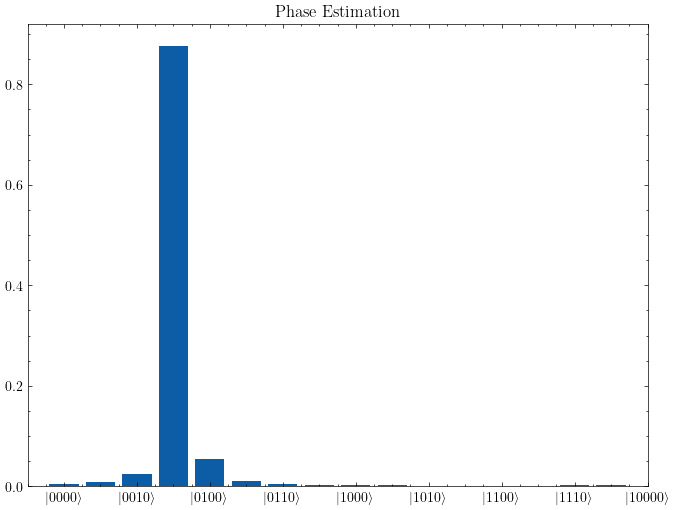

In [318]:
phase = 0.2
qpe = QPE(4, phase)
qpe.controlledU()
qpe.IQFT()

state = f"{int(np.argmax(qpe.normalise([abs(x) for x in qpe.register]))):0{qpe.n_qubits}b}"
estimate = 0
for i, bit in enumerate(state):
    estimate += 2**(-i-1) * int(bit)

xs = np.arange(0, qpe.N)
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.xaxis.set_major_formatter(lambda x, _: f"$\\mid${int(x):0{qpe.n_qubits}b}$\\rangle$")
ax.set_xlim(min(xs)-1, max(xs)+1)
ax.bar(xs, qpe.normalise([abs(x) for x in qpe.register])**2)
ax.set_title(r"Phase Estimation")

print("most likely to collapse to:", state, "\nestimate phase:", estimate, "\ntrue phase:", phase)
